En el presente Notebook se va a evaluar como se ajusta el modelo de 1 step prediction a los datos de emisiones, generación y demanda, para a continuación, decidir si son lo suficientemente buenos como para hacerles tuning y realizar predicciones futuras de los datos.

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

import json
from pandas import Timestamp

import requests
from pprint import pprint

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, Dropout

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import pickle

import os

plt.rcParams["figure.figsize"] = (20, 8)

# GENERACIÓN X TECNOLOGÍA

En primer lugar, cargamos el DataFrame con los datos diarios de Generación por Tecnología.

In [2]:
gen_x_tech=pd.read_csv("GeneracionDiariaXTecnologia.csv")

In [3]:
gen_x_tech.shape

(3298, 16)

Creamos los diferentes modelos, almacenando dichos modelos y las métricas en un DataFrame para una mejor visualización de los resultados.

In [4]:
datos_modelos=list()

for tech in gen_x_tech.columns[1:]:
    
    datos = np.array(gen_x_tech[tech])
    datos = datos.reshape(-1,1)

    scaler = MinMaxScaler()
    datos = scaler.fit_transform(datos)

    #datos.shape
    T = 20
    X = list()
    y = list()

    for t in range(len(datos) - T):
    
        # Toma valores de X de t en t con stride de 1
        x = datos[t : t + T]
        X.append(x)
    
        # Toma los valores de t en t
        y_ = datos[t + T]
        y.append(y_)

    # Transformamos a np.array y ajustamos las dimensiones
    # Para entrar en el modelo debe de tener 3 dimensiones
    X = np.array(X).reshape(-1, T, 1)
    y = np.array(y)
    N = len(X)

    #print(f"X: {X.shape}\ty: {y.shape}")

    model = Sequential()

    model.add(Input(shape = (T, 1)))

    model.add(SimpleRNN(units = 200, activation = "relu"))
    model.add(Dense(units = 60, activation="relu")) 
    model.add(Dense(units = 30, activation="relu")) 
    model.add(Dense(units = 15, activation="relu")) 
    model.add(Dense(units = 1))

    model.compile(optimizer = "adam", loss = "mse")

    #model.summary()
    
    history = model.fit(x = X[:3055],
                        y = y[:3055],
                        validation_data = (X[3055:], y[3055:]),
                        epochs = 100)
    
    ## loss
    #plt.plot(history.history["loss"], label = "loss")
    #plt.plot(history.history["val_loss"], label = "val_loss")
    #plt.legend()
    #plt.title(f"{tech}")
    #plt.ylim(0, 1)
    #plt.savefig(f"History 1 Step - {tech}.png")
    #plt.show()
    
    # "1 - Step Predictions"

    # Toma un valor y predice el siguiente

    validation_target = y[3055:]
    validation_predictions = list()

    i = -223

    while len(validation_predictions) < len(validation_target):
    
        # Predice el siguiente valor de X[i]
        p = model.predict(X[i].reshape(1, -1, 1))[0, 0]
        i += 1
    
        validation_predictions.append(p)
    
    #plt.plot(validation_target, label = "forecast target")
    #plt.plot(validation_predictions, label = "forecast prediction")
    #plt.title(f"{tech}")
    #plt.legend()
    #plt.savefig(f"Validation 1 Step - {tech}.png")
    #plt.show()
    
    yhat_modelo = np.array(validation_predictions)

    yhat_modelo = scaler.inverse_transform(yhat_modelo.reshape(-1,1))
    
    target=np.array(validation_target)

    target = scaler.inverse_transform(target.reshape(-1,1))
    
    mae = mean_absolute_error(target, yhat_modelo)
    mse = mean_squared_error(target, yhat_modelo)
    r2 = r2_score(target, yhat_modelo)
    
    datos_modelos.append([tech, model, mae, mse, r2])
    
df_modelos_generacion = pd.DataFrame(data = datos_modelos, columns = ["Nombre", "Modelo", "mae", "mse", "r2"])

Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 2/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 3/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 4/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 5/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 6/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 7/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 8/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 10/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0043

1/1 [==============================] - 0s 24ms/step
Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0857 - val_loss: 0.0129
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0090 - val_loss: 0.0095
Epoch 3/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0062 - val_loss: 0.0081
Epoch 4/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0055 - val_loss: 0.0106
Epoch 5/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0069
Epoch 6/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0064
Epoch 7/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0039 - val_loss: 0.0060
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 9/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0062
Epoch 10/100
96/96 [============================

1/1 [==============================] - 0s 28ms/step
Epoch 1/100
96/96 [==============================] - 3s 14ms/step - loss: 0.0264 - val_loss: 2.4726e-04
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0056 - val_loss: 1.3138e-04
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 2.6179e-04
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 2.1448e-04
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 3.2491e-04
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 4.1903e-04
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 5.1185e-04
Epoch 8/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 1.0121e-04
Epoch 9/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 1.0065e-04
Epoch 10/100

96/96 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 1.5353e-04
Epoch 56/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 1.7873e-04
Epoch 57/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 1.1165e-04
Epoch 58/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 2.1023e-04
Epoch 59/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 9.8839e-05
Epoch 60/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 9.8754e-05
Epoch 61/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 1.1227e-04
Epoch 62/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 1.5417e-04
Epoch 63/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 9.2746e-05
Epoch 64/100
96/96 [==============================] - 1s 10ms/step -

1/1 [==============================] - 0s 26ms/step
Epoch 1/100
96/96 [==============================] - 3s 15ms/step - loss: 0.0152 - val_loss: 0.0054
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.0043
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 9/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 10/100
96/96 [============================

1/1 [==============================] - 0s 28ms/step
Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0258 - val_loss: 0.0110
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0081 - val_loss: 0.0094
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0076 - val_loss: 0.0097
Epoch 5/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0074 - val_loss: 0.0088
Epoch 6/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0071 - val_loss: 0.0092
Epoch 7/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0070 - val_loss: 0.0093
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0070 - val_loss: 0.0092
Epoch 10/100
96/96 [============================

1/1 [==============================] - 0s 28ms/step
Epoch 1/100
96/96 [==============================] - 3s 12ms/step - loss: 0.0189 - val_loss: 0.0034
Epoch 2/100
96/96 [==============================] - 1s 9ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 0.0029
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0050 - val_loss: 0.0029
Epoch 8/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 9/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 10/100
96/96 [=============================

96/96 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 57/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 58/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 59/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 60/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 61/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 62/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0035
Epoch 63/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 64/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 65/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0035 - val_loss: 0.0038
Epo

96/96 [==============================] - 1s 10ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 4/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0068 - val_loss: 0.0074
Epoch 5/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 6/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0067 - val_loss: 0.0081
Epoch 7/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0062 - val_loss: 0.0075
Epoch 9/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0063 - val_loss: 0.0086
Epoch 10/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 11/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0063 - val_loss: 0.0074
Epoch 12/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 13/

1/1 [==============================] - 0s 19ms/step
Epoch 1/100
96/96 [==============================] - 3s 12ms/step - loss: 0.0250 - val_loss: 0.0270
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0175 - val_loss: 0.0256
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0171 - val_loss: 0.0268
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0174 - val_loss: 0.0262
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0167 - val_loss: 0.0257
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0167 - val_loss: 0.0277
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0167 - val_loss: 0.0257
Epoch 8/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0170 - val_loss: 0.0262
Epoch 9/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0169 - val_loss: 0.0281
Epoch 10/100
96/96 [============================

1/1 [==============================] - 0s 30ms/step
Epoch 1/100
96/96 [==============================] - 3s 15ms/step - loss: 0.0234 - val_loss: 0.0219
Epoch 2/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0181 - val_loss: 0.0187
Epoch 3/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0173 - val_loss: 0.0196
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0177 - val_loss: 0.0209
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0174 - val_loss: 0.0187
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0169 - val_loss: 0.0184
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0171 - val_loss: 0.0197
Epoch 8/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0172 - val_loss: 0.0187
Epoch 9/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0169 - val_loss: 0.0188
Epoch 10/100
96/96 [============================

96/96 [==============================] - 1s 10ms/step - loss: 0.0069 - val_loss: 0.0291
Epoch 60/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0065 - val_loss: 0.0306
Epoch 61/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0065 - val_loss: 0.0303
Epoch 62/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0063 - val_loss: 0.0284
Epoch 63/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0060 - val_loss: 0.0304
Epoch 64/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0060 - val_loss: 0.0291
Epoch 65/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0054 - val_loss: 0.0319
Epoch 66/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0059 - val_loss: 0.0306
Epoch 67/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0307
Epoch 68/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 0.0294
Epo

96/96 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 0.0098
Epoch 7/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0087
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0111
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0022 - val_loss: 0.0088
Epoch 10/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 0.0106
Epoch 11/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0092
Epoch 12/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0022 - val_loss: 0.0121
Epoch 13/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0092
Epoch 14/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0170
Epoch 15/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0102
Epoch 

1/1 [==============================] - 0s 36ms/step
Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0663 - val_loss: 0.0203
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0080 - val_loss: 0.0209
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0069 - val_loss: 0.0189
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0062 - val_loss: 0.0201
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0059 - val_loss: 0.0176
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0056 - val_loss: 0.0168
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0165
Epoch 8/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 0.0163
Epoch 9/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0145
Epoch 10/100
96/96 [============================

1/1 [==============================] - 0s 25ms/step
Epoch 1/100
96/96 [==============================] - 3s 15ms/step - loss: 0.0144 - val_loss: 0.0073
Epoch 2/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0052
Epoch 3/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0026 - val_loss: 0.0041
Epoch 4/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 5/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 6/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0044
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 8/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 9/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 10/100
96/96 [============================

96/96 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0048
Epoch 63/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 64/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 0.0042
Epoch 65/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 66/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 67/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 68/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 69/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 70/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 71/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 0.0050
Epo

96/96 [==============================] - 1s 12ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 10/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 11/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 12/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 13/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 14/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 15/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 16/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 17/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 18/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0017
Epo

1/1 [==============================] - 0s 28ms/step
Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0226 - val_loss: 0.0049
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 4/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 6/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 10/100
96/96 [============================

1/1 [==============================] - 0s 22ms/step
Epoch 1/100
96/96 [==============================] - 3s 12ms/step - loss: 0.0350 - val_loss: 0.0215
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0200 - val_loss: 0.0184
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0202 - val_loss: 0.0190
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0198 - val_loss: 0.0188
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0197 - val_loss: 0.0193
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0196 - val_loss: 0.0195
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0199 - val_loss: 0.0185
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0203 - val_loss: 0.0180
Epoch 9/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0193 - val_loss: 0.0223
Epoch 10/100
96/96 [============================

96/96 [==============================] - 1s 10ms/step - loss: 0.0090 - val_loss: 0.0246
Epoch 66/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0087 - val_loss: 0.0229
Epoch 67/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0074 - val_loss: 0.0240
Epoch 68/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0071 - val_loss: 0.0257
Epoch 69/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0073 - val_loss: 0.0239
Epoch 70/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0079 - val_loss: 0.0211
Epoch 71/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0071 - val_loss: 0.0246
Epoch 72/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0069 - val_loss: 0.0268
Epoch 73/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0071 - val_loss: 0.0222
Epoch 74/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0233
Epo

In [5]:
df_modelos_generacion

,Nombre,Modelo,mae,mse,r2
0,Generación Hidráulica GWh,<keras.src.engine.sequential.Sequential object...,11.552519,247.728173,0.763629
1,Generación Nuclear GWh,<keras.src.engine.sequential.Sequential object...,3.413671,43.448613,0.890883
2,Generación Carbón GWh,<keras.src.engine.sequential.Sequential object...,1.538920,4.861795,0.658635
3,Generación Motores diésel GWh,<keras.src.engine.sequential.Sequential object...,0.482279,0.368655,0.648402
4,Generación Turbina de gas GWh,<keras.src.engine.sequential.Sequential object...,0.448451,0.338071,0.340733
5,Generación Turbina de vapor GWh,<keras.src.engine.sequential.Sequential object...,0.450727,0.323037,0.440798
6,Generación Ciclo combinado GWh,<keras.src.engine.sequential.Sequential object...,30.541694,1544.329718,0.432104
7,Generación Hidroeólica GWh,<keras.src.engine.sequential.Sequential object...,0.021253,0.000851,0.612943
8,Generación Eólica GWh,<keras.src.engine.sequential.Sequential object...,56.115763,5524.240407,0.295996
9,Generación Solar fotovoltaica GWh,<keras.src.engine.sequential.Sequential object...,13.230272,272.927615,0.779065


In [6]:
df_modelos_generacion.to_csv("Generación por tecnología - 1 STEP.csv", index = False)

Como se puede observar, la mayoría de los modelos presentan un r2 bajo, por lo que las predicciones a largo plazo no serían precisas. En este caso, se están determinando y evaluando la generación de cada una de las tecnologías disponibles, por lo que se decide no hacer ningún modelo de Machine Learning para este conjunto de datos, puesto que no sería relevante centrarse exclusivamente en un par de tecnologías.

# Generación diaria renovable - No renovable

In [7]:
gen_ren_noren=pd.read_csv("GeneracionDiariaRenNoRen.csv")

In [8]:
datos_modelos=list()

for tech in gen_ren_noren.columns[1:]:
    
    datos = np.array(gen_ren_noren[tech])
    datos = datos.reshape(-1,1)

    scaler = MinMaxScaler()
    datos = scaler.fit_transform(datos)

    #datos.shape
    T = 20
    X = list()
    y = list()

    for t in range(len(datos) - T):
    
        # Toma valores de X de t en t con stride de 1
        x = datos[t : t + T]
        X.append(x)
    
        # Toma los valores de t en t
        y_ = datos[t + T]
        y.append(y_)

    # Transformamos a np.array y ajustamos las dimensiones
    # Para entrar en el modelo debe de tener 3 dimensiones
    X = np.array(X).reshape(-1, T, 1)
    y = np.array(y)
    N = len(X)

    #print(f"X: {X.shape}\ty: {y.shape}")

    model = Sequential()

    model.add(Input(shape = (T, 1)))

    model.add(SimpleRNN(units = 200, activation = "relu"))
    model.add(Dense(units = 60, activation="relu")) 
    model.add(Dense(units = 30, activation="relu")) 
    model.add(Dense(units = 15, activation="relu")) 
    model.add(Dense(units = 1))

    model.compile(optimizer = "adam", loss = "mse")

#     model.summary()
    
    history = model.fit(x = X[:3055],
                        y = y[:3055],
                        validation_data = (X[3055:], y[3055:]),
                        epochs = 100)
    
#     # loss
#     plt.plot(history.history["loss"], label = "loss")
#     plt.plot(history.history["val_loss"], label = "val_loss")
#     plt.legend()
#     plt.title(f"{tech}")
#     plt.ylim(0, 1)
#     plt.savefig(f"History 1 Step - {tech}.png")
#     plt.show()
    
    # "1 - Step Predictions"

    # Toma un valor y predice el siguiente

    validation_target = y[3055:]
    validation_predictions = list()

    i = -223

    while len(validation_predictions) < len(validation_target):
    
        # Predice el siguiente valor de X[i]
        p = model.predict(X[i].reshape(1, -1, 1))[0, 0]
        i += 1
    
        validation_predictions.append(p)
    
    #plt.plot(validation_target, label = "forecast target")
    #plt.plot(validation_predictions, label = "forecast prediction")
    #plt.title(f"{tech}")
    #plt.legend()
    #plt.savefig(f"Validation 1 Step - {tech}.png")
    #plt.show()
    
    yhat_modelo=np.array(validation_predictions)

    yhat_modelo = scaler.inverse_transform(yhat_modelo.reshape(-1,1))
    
    target=np.array(validation_target)

    target = scaler.inverse_transform(target.reshape(-1,1))
    
    mae = mean_absolute_error(target, yhat_modelo)
    mse = mean_squared_error(target, yhat_modelo)
    r2 = r2_score(target, yhat_modelo)
    
    datos_modelos.append([tech, model, mae, mse, r2])
    
df_modelos_ren_noren = pd.DataFrame(data = datos_modelos, columns = ["Nombre", "Modelo", "mae", "mse", "r2"])

Epoch 1/100
96/96 [==============================] - 3s 14ms/step - loss: 0.0201 - val_loss: 0.0143
Epoch 2/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 3/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0111 - val_loss: 0.0130
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0108 - val_loss: 0.0110
Epoch 7/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0112 - val_loss: 0.0126
Epoch 8/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 9/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 10/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0107 - val_loss: 0.0113

1/1 [==============================] - 0s 21ms/step
Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0183 - val_loss: 0.0076
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 4/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 5/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 6/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0051 - val_loss: 0.0043
Epoch 7/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 8/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 10/100
96/96 [============================

1/1 [==============================] - 0s 24ms/step


In [9]:
df_modelos_ren_noren

,Nombre,Modelo,mae,mse,r2
0,Generación Renovables GWh,<keras.src.engine.sequential.Sequential object...,56.068698,5328.325269,0.153279
1,Generación No renovables GWh,<keras.src.engine.sequential.Sequential object...,32.442158,1638.551596,0.542636


In [10]:
df_modelos_ren_noren.to_csv("Generación renovable vs no renovable - 1 STEP.csv", index = False)

Al igual que para el conjunto de datos del apartado anterior, los valores de r2 son demasiado bajos como para obtener un modelo de predicción que se ajuste de manera medianamente precisa a la realidad. De este modo, se excluyen estos datos de la elaboración de modelos de ML.

# Emisiones

In [11]:
emisiones=pd.read_csv("EmisionesDiarias.csv")
#Se elimina porque da error con el punto a la hora de crear archivos y además es una columna correlacionada con otra.
emisiones.drop("tCO2 eq./MWh", axis = 1, inplace = True) 

In [12]:
emisiones

,Fechas,Emisiones Motores diésel,Emisiones Turbina de gas,Emisiones Turbina de vapor,Emisiones Ciclo combinado,Emisiones Cogeneración,Emisiones Residuos no renovables,Total tCO2 eq.,Emisiones Carbón
0,2014-08-01,7921.88,2236.33,5361.02,30352.01,25975.34,1475.83,247145.18,173822.78
1,2014-08-02,7784.07,1678.06,4751.97,22092.77,23523.61,1471.15,201704.57,140402.94
2,2014-08-03,7483.51,1665.99,4079.90,26182.17,21659.56,1478.46,216905.44,154355.84
3,2014-08-04,8053.26,2235.35,5407.29,35543.03,24336.56,1309.36,261151.06,184266.22
4,2014-08-05,7837.00,2214.94,5232.38,37612.21,25107.16,1262.29,264824.36,185558.37
...,...,...,...,...,...,...,...,...,...
3293,2023-08-07,6267.65,1089.33,3385.86,35794.93,14603.68,932.89,70747.57,8673.22
3294,2023-08-08,6379.66,1359.06,3392.74,61738.56,17280.14,906.62,104867.06,13810.27
3295,2023-08-09,5700.36,1505.42,2581.22,95524.03,17237.37,895.24,138021.13,14577.50
3296,2023-08-10,6027.98,1467.55,1975.61,72942.90,17023.88,918.50,113880.03,13523.62


In [13]:
datos_modelos=list()

for tech in emisiones.columns[1:]:
    
    datos = np.array(emisiones[tech])
    datos = datos.reshape(-1,1)

    scaler = MinMaxScaler()
    datos = scaler.fit_transform(datos)

    #datos.shape
    T = 20
    X = list()
    y = list()

    for t in range(len(datos) - T):
    
        # Toma valores de X de t en t con stride de 1
        x = datos[t : t + T]
        X.append(x)
    
        # Toma los valores de t en t
        y_ = datos[t + T]
        y.append(y_)

    # Transformamos a np.array y ajustamos las dimensiones
    # Para entrar en el modelo debe de tener 3 dimensiones
    X = np.array(X).reshape(-1, T, 1)
    y = np.array(y)
    N = len(X)

    #print(f"X: {X.shape}\ty: {y.shape}")

    model = Sequential()

    model.add(Input(shape = (T, 1)))

    model.add(SimpleRNN(units = 200, activation = "relu"))
    model.add(Dense(units = 60, activation="relu")) 
    model.add(Dense(units = 30, activation="relu")) 
    model.add(Dense(units = 15, activation="relu")) 
    model.add(Dense(units = 1))

    model.compile(optimizer = "adam", loss = "mse")

#     model.summary()
    
    history = model.fit(x = X[:3055],
                        y = y[:3055],
                        validation_data = (X[3055:], y[3055:]),
                        epochs = 100)
    
#     # loss
#     plt.plot(history.history["loss"], label = "loss")
#     plt.plot(history.history["val_loss"], label = "val_loss")
#     plt.legend()
#     plt.title(f"{tech}")
#     plt.ylim(0, 1)
#     plt.savefig(f"History 1 Step - {tech}.png")
#     plt.show()
    
    # "1 - Step Predictions"

    # Toma un valor y predice el siguiente

    validation_target = y[3055:]
    validation_predictions = list()

    i = -223

    while len(validation_predictions) < len(validation_target):
    
        # Predice el siguiente valor de X[i]
        p = model.predict(X[i].reshape(1, -1, 1))[0, 0]
        i += 1
    
        validation_predictions.append(p)
    
#     plt.plot(validation_target, label = "forecast target")
#     plt.plot(validation_predictions, label = "forecast prediction")
#     plt.title(f"{tech}")
#     plt.legend()
#     plt.savefig(f"Validation 1 Step - {tech}.png")
#     plt.show()
    
    yhat_modelo=np.array(validation_predictions)

    yhat_modelo = scaler.inverse_transform(yhat_modelo.reshape(-1,1))
    
    target=np.array(validation_target)

    target = scaler.inverse_transform(target.reshape(-1,1))
    
    mae = mean_absolute_error(target, yhat_modelo)
    mse = mean_squared_error(target, yhat_modelo)
    r2 = r2_score(target, yhat_modelo)
    
    datos_modelos.append([tech, model, mae, mse, r2])
    
df_modelos_emisiones = pd.DataFrame(data = datos_modelos, columns = ["Nombre", "Modelo", "mae", "mse", "r2"])

Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0140 - val_loss: 0.0030
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 4/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 5/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 6/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 7/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 8/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0028

1/1 [==============================] - 0s 30ms/step
Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0232 - val_loss: 0.0109
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0100 - val_loss: 0.0103
Epoch 3/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0088 - val_loss: 0.0110
Epoch 4/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0088 - val_loss: 0.0125
Epoch 5/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0083 - val_loss: 0.0110
Epoch 6/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0080 - val_loss: 0.0117
Epoch 7/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0082 - val_loss: 0.0099
Epoch 8/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0079 - val_loss: 0.0096
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0079 - val_loss: 0.0106
Epoch 10/100
96/96 [============================

1/1 [==============================] - 0s 21ms/step
Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0153 - val_loss: 0.0037
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 3/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 4/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 5/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 6/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 7/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 8/100
96/96 [==============================] - 2s 16ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 10/100
96/96 [============================

96/96 [==============================] - 1s 11ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 58/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 59/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 60/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 61/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 62/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 63/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 64/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 65/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 66/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0032 - val_loss: 0.0038
Epo

96/96 [==============================] - 1s 11ms/step - loss: 0.0069 - val_loss: 0.0071
Epoch 5/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 6/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 7/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0064 - val_loss: 0.0080
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0068 - val_loss: 0.0075
Epoch 10/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 11/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 12/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 13/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0062 - val_loss: 0.0086
Epoch 14

1/1 [==============================] - 0s 27ms/step
Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0261 - val_loss: 0.0074
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 3/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 4/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 5/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0042
Epoch 6/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 7/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 10/100
96/96 [============================

1/1 [==============================] - 0s 22ms/step
Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0337 - val_loss: 0.0066
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 3/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 5/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 6/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 7/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 8/100
96/96 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 9/100
96/96 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/100
96/96 [============================

96/96 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.0060
Epoch 61/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 62/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0048
Epoch 63/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 64/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 65/100
96/96 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0071
Epoch 66/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0053
Epoch 67/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0056
Epoch 68/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0024 - val_loss: 0.0083
Epoch 69/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0025 - val_loss: 0.0082
Epo

96/96 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 9/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 10/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 11/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 12/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 13/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 14/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 15/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 16/100
96/96 [==============================] - 1s 13ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch

1/1 [==============================] - 0s 29ms/step
Epoch 1/100
96/96 [==============================] - 3s 13ms/step - loss: 0.0133 - val_loss: 1.3526e-04
Epoch 2/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0052 - val_loss: 2.0618e-04
Epoch 3/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0047 - val_loss: 2.6826e-04
Epoch 4/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 8.8091e-05
Epoch 5/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0045 - val_loss: 9.0287e-05
Epoch 6/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0043 - val_loss: 1.0595e-04
Epoch 7/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 8/100
96/96 [==============================] - 1s 13ms/step - loss: 0.0045 - val_loss: 2.6661e-04
Epoch 9/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0041 - val_loss: 1.0888e-04
Epoch 10/100
96/

96/96 [==============================] - 1s 12ms/step - loss: 0.0038 - val_loss: 5.6305e-04
Epoch 35/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 1.1804e-04
Epoch 36/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0032 - val_loss: 5.2672e-04
Epoch 37/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0031 - val_loss: 1.2696e-04
Epoch 38/100
96/96 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 1.0151e-04
Epoch 39/100
96/96 [==============================] - 1s 13ms/step - loss: 0.0031 - val_loss: 5.7494e-04
Epoch 40/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 3.6979e-04
Epoch 41/100
96/96 [==============================] - 1s 13ms/step - loss: 0.0030 - val_loss: 1.2705e-04
Epoch 42/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0031 - val_loss: 1.5919e-04
Epoch 43/100
96/96 [==============================] - 1s 12ms/step -

1/1 [==============================] - 0s 25ms/step


In [14]:
df_modelos_emisiones

,Nombre,Modelo,mae,mse,r2
0,Emisiones Motores diésel,<keras.src.engine.sequential.Sequential object...,338.656831,1.826697e+05,0.617082
1,Emisiones Turbina de gas,<keras.src.engine.sequential.Sequential object...,483.663275,3.961876e+05,0.275118
2,Emisiones Turbina de vapor,<keras.src.engine.sequential.Sequential object...,433.377189,3.035975e+05,0.351604
3,Emisiones Ciclo combinado,<keras.src.engine.sequential.Sequential object...,10368.735426,1.790126e+08,0.529873
4,Emisiones Cogeneración,<keras.src.engine.sequential.Sequential object...,1427.056607,3.800290e+06,0.657578
5,Emisiones Residuos no renovables,<keras.src.engine.sequential.Sequential object...,126.576173,3.004381e+04,0.417191
6,Total tCO2 eq.,<keras.src.engine.sequential.Sequential object...,11655.455767,2.318385e+08,0.606170
7,Emisiones Carbón,<keras.src.engine.sequential.Sequential object...,1659.377295,5.047759e+06,0.601527


In [15]:
df_modelos_emisiones.to_csv("Emisiones por tecnología - 1 STEP.csv", index = False)

Al igual que con los datos de generación energética, los valores de emisiones no permiten obtener modelos de predicción precisos. Esto puede ser debido a la gran cantidad de factores externos que tienen alguna repercusión en cada una de las tecnologías, como pueden ser factores climatológicos, socioeconómicos o políticos.

# DEMANDA NACIONAL

In [16]:
demanda_nacional=pd.read_csv("demanda_nacional.csv")
demanda_nacional

,Fecha,Energia Consumida Mw/h
0,2011-01-01,605.99
1,2011-01-02,641.86
2,2011-01-03,801.30
3,2011-01-04,833.25
4,2011-01-05,803.48
...,...,...
4611,2023-08-17,705.51
4612,2023-08-18,706.09
4613,2023-08-19,664.26
4614,2023-08-20,648.87


Epoch 1/100
137/137 [==============================] - 4s 15ms/step - loss: 0.0282 - val_loss: 0.0067
Epoch 2/100
137/137 [==============================] - 2s 12ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 3/100
137/137 [==============================] - 2s 14ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 4/100
137/137 [==============================] - 2s 15ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 5/100
137/137 [==============================] - 2s 15ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 6/100
137/137 [==============================] - 2s 13ms/step - loss: 0.0036 - val_loss: 0.0028
Epoch 7/100
137/137 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 8/100
137/137 [==============================] - 2s 14ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 9/100
137/137 [==============================] - 2s 12ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 10/100
137/137 [==============================] - 2s 13ms/step - loss: 0.002

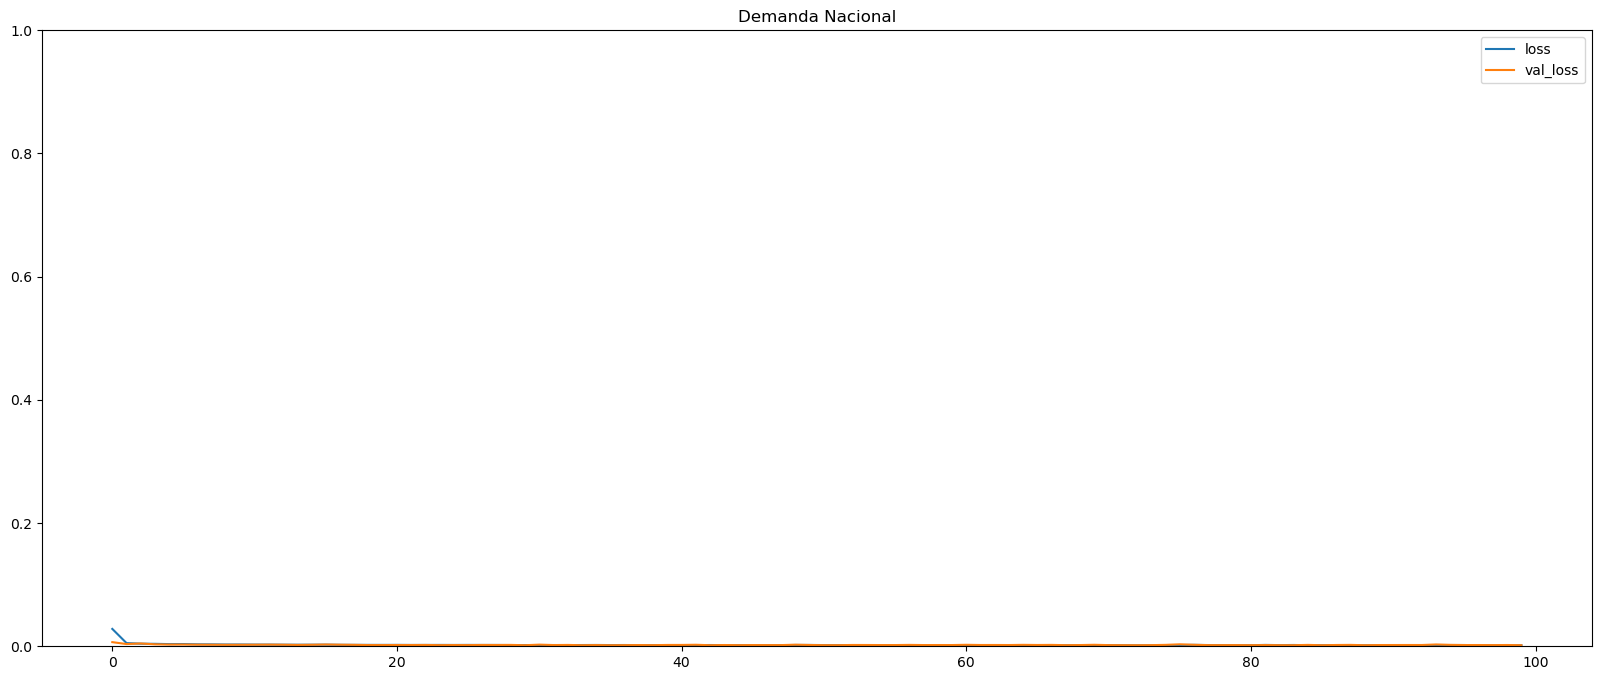

1/1 [==============================] - 0s 28ms/step


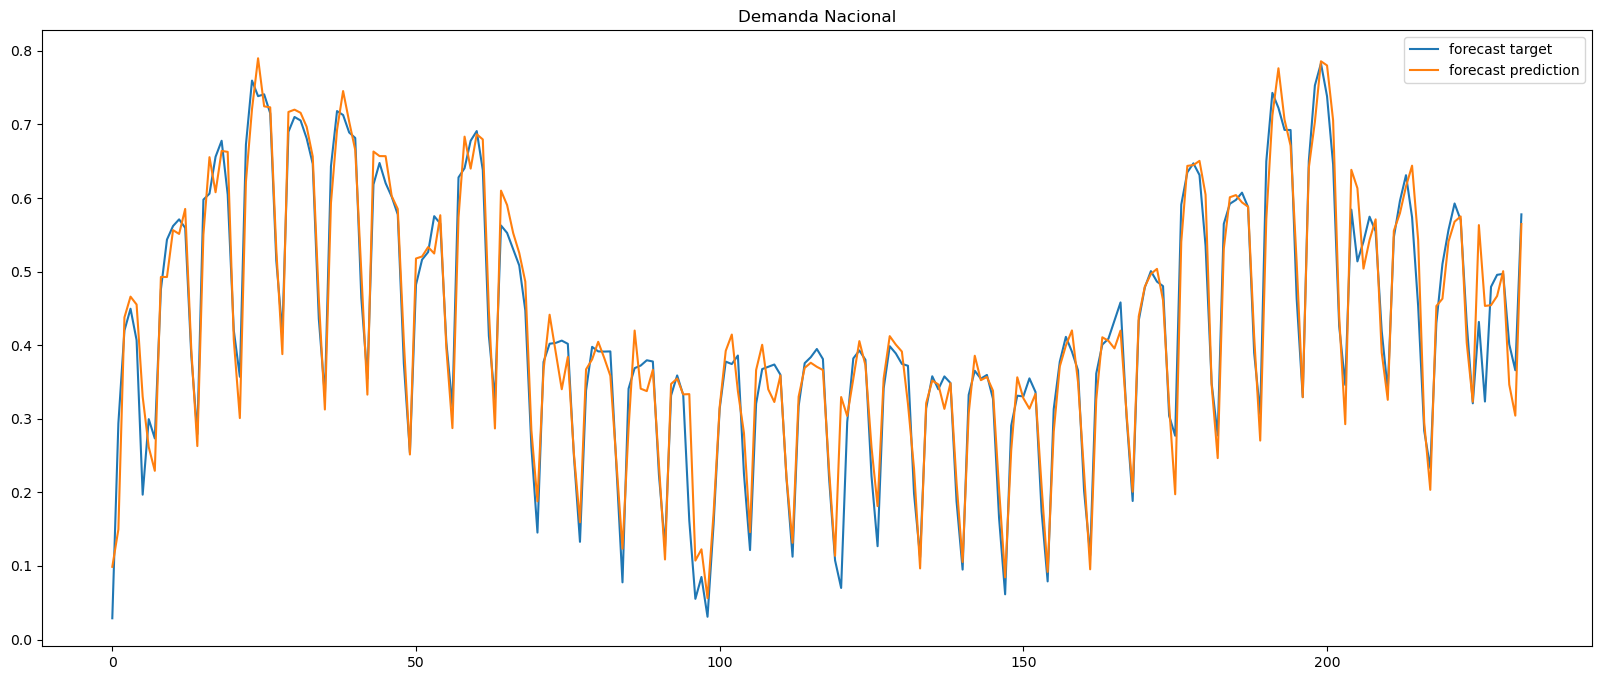

In [17]:
datos = np.array(demanda_nacional["Energia Consumida Mw/h"])
datos = datos.reshape(-1,1)

scaler = MinMaxScaler()
datos = scaler.fit_transform(datos)

#datos.shape
T = 20
X = list()
y = list()

for t in range(len(datos) - T):
  
 # Toma valores de X de t en t con stride de 1
    x = datos[t : t + T]
    X.append(x)

     # Toma los valores de t en t
    y_ = datos[t + T]
    y.append(y_)

 # Transformamos a np.array y ajustamos las dimensiones
 # Para entrar en el modelo debe de tener 3 dimensiones
X = np.array(X).reshape(-1, T, 1)
y = np.array(y)
N = len(X)

 #print(f"X: {X.shape}\ty: {y.shape}")

model = Sequential()

model.add(Input(shape = (T, 1)))

model.add(SimpleRNN(units = 200, activation = "relu"))
model.add(Dense(units = 60, activation="relu")) 
model.add(Dense(units = 30, activation="relu")) 
model.add(Dense(units = 15, activation="relu")) 
model.add(Dense(units = 1))

model.compile(optimizer = "adam", loss = "mse")

#    model.summary()
    
history = model.fit(x = X[:4363],
                        y = y[:4363],
                        validation_data = (X[4363:], y[4363:]),
                        epochs = 100)
    
 # loss
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend()
plt.title(f"Demanda Nacional")
plt.ylim(0, 1)
plt.savefig(f"History 1 Step - Demanda Nacional.png")
plt.show()
    
# "1 - Step Predictions"

 # Toma un valor y predice el siguiente

validation_target = y[4363:]
validation_predictions = list()
i = -233
while len(validation_predictions) < len(validation_target):
 
    # Predice el siguiente valor de X[i]
    p = model.predict(X[i].reshape(1, -1, 1))[0, 0]
    i += 1

    validation_predictions.append(p)
    
plt.plot(validation_target, label = "forecast target")
plt.plot(validation_predictions, label = "forecast prediction")
plt.title(f"Demanda Nacional")
plt.legend()
plt.savefig(f"Validation 1 Step - Demanda Nacional.png")
plt.show()
    
yhat_modelo=np.array(validation_predictions)

yhat_modelo = scaler.inverse_transform(yhat_modelo.reshape(-1,1))
    
target = np.array(validation_target)

target = scaler.inverse_transform(target.reshape(-1,1))
    
mae = mean_absolute_error(target, yhat_modelo)
mse = mean_squared_error(target, yhat_modelo)
r2 = r2_score(target, yhat_modelo)

    
df_modelos_demanda_nacional = pd.DataFrame(data = [["Demanda", model, mae, mse, r2]], columns = ["Nombre", "Modelo", "mae", "mse", "r2"])

In [18]:
df_modelos_demanda_nacional

,Nombre,Modelo,mae,mse,r2
0,Demanda,<keras.src.engine.sequential.Sequential object...,12.770258,329.78351,0.942019


In [19]:
df_modelos_demanda_nacional.to_csv("Demanda nacional - 1 STEP", index = False)

Como se puede observar, los datos de demanda energética nacional permiten obtener un valor de r2 muy elevado. Es por esto que se seleccionan estos datos para realizar pruebas con distintos modelos, mejorándolos, para así seleccionar el que proporcione un mejor ajuste y predicciones a largo plazo.